In [1]:
import numpy as np
import scipy
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])

<ipython-input-2-30203b14c1a0>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/Han/Desktop/Box Sync/Stat 485/Final Project/cleaned.data.csv', index_col=[0])


Change loan_approved to 1 or 0 and move it to the last column

In [3]:
label = df['loan_approved']
df = df.drop(['loan_approved'], axis =1)
df.insert(loc=23, column = 'loan_approved', value = label)

In [4]:
df.loan_approved= df.loan_approved.astype(str).map({'No':0, 'Yes':1})

Drop redundant columns, county_name, county_code, denials

In [5]:
df = df.drop(['county_name','county_code','denials'], axis = 1)

Drop column: hoepa_status_name, because it is perfectly in line with the approval of the loan

In [6]:
df = df.drop(['hoepa_status_name'], axis = 1)

Process label encoder on the object variables to work with sk.classifier

In [7]:
df.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                 object
owner_occupancy_name               object
loan_type_name                     object
loan_purpose_name                  object
lien_status_name                   object
co_applicant_sex_name              object
census_tract_number               float64
applicant_sex_name                 object
agency_abbr                        object
applicant_race                     object
co_applicant_race                  object
loan_approved                       int64
dtype: object

In [8]:
le = preprocessing.LabelEncoder()
for column_name in df.columns:
    if df[column_name].dtype == object:
        df[column_name] = le.fit_transform(df[column_name])
    else:
        pass

Adjust a few column's dtype

In [9]:
#df.loc[:,'property_type_name':'loan_approved'] = df.loc[:,'property_type_name':'loan_approved'].apply(pd.Categorical)

List the # of copies of each class

In [10]:
df.loan_approved.value_counts()

1    251758
0     60016
Name: loan_approved, dtype: int64

Prepare the Y/label and the X

In [11]:
y = df.loan_approved

In [12]:
x = df.drop('loan_approved', axis =1)

In [13]:
x.dtypes

tract_to_msamd_income             float64
population                          int64
minority_population               float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
loan_amount_000s                    int64
hud_median_family_income            int64
applicant_income_000s               int64
property_type_name                  int32
owner_occupancy_name                int32
loan_type_name                      int32
loan_purpose_name                   int32
lien_status_name                    int32
co_applicant_sex_name               int32
census_tract_number               float64
applicant_sex_name                  int32
agency_abbr                         int32
applicant_race                      int32
co_applicant_race                   int32
dtype: object

In [14]:
x.head()

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,loan_type_name,loan_purpose_name,lien_status_name,co_applicant_sex_name,census_tract_number,applicant_sex_name,agency_abbr,applicant_race,co_applicant_race
1,121.690002,8381,23.790001,2175,2660,227,73300,116,1,2,0,2,1,2,413.27,0,0,5,5
2,83.370003,4915,23.990000,1268,1777,240,57900,42,1,2,1,1,1,3,9208.01,2,3,4,7
3,91.129997,5075,11.820000,1136,1838,241,73300,117,1,2,0,2,1,0,414.00,2,3,8,9
4,146.169998,5032,8.590000,1525,1820,351,73300,315,1,2,0,2,1,0,405.10,2,4,5,5
5,162.470001,5183,10.500000,1705,2104,417,78100,114,1,2,0,0,1,2,907.00,0,1,8,9


Split

In [15]:
seed = 127
xtrain,xtest, ytrain, ytest = train_test_split(x,y,test_size =.2, random_state= seed)

Let do some un-tuned prediction and use them as the baseline performance

In [16]:
rfc = RandomForestClassifier() # examplify
rfc = rfc.fit(xtrain,ytrain) # use the class' fit

result = rfc.score(xtest,ytest) # get the score/accuracy with no tuning to see some preliminary results
result

0.8200785823109614

We can try to print all trees out, although there is definitely no need

In [17]:
#print('All tree: %s' %r fc.estimators_)

We can also print out all predictions' probabilities

In [18]:
print('Every predition being 1 with probability of: %s' % rfc.predict_proba(xtest)[:,1]) # if we change the index 1 to 0, we get the proba of prediction being 0

Every predition being 1 with probability of: [0.91 0.94 0.97 ... 0.52 0.58 0.76]


Check on the ROC AUC

In [19]:
roc_auc_score(ytest, rfc.predict_proba(xtest)[:,1])

0.7393356982971137

In [20]:
print('The importance of each feature: %s' % rfc.feature_importances_)

The importance of each feature: [0.07032538 0.06580618 0.0702969  0.06476237 0.06558307 0.17010399
 0.02580213 0.18849035 0.00558272 0.01041118 0.01981308 0.04654867
 0.00661021 0.01714157 0.06979356 0.02210432 0.03478327 0.02782951
 0.01821154]


Feature Ranking
 1) applicant_income_000s          0.188490
 2) loan_amount_000s               0.170104
 3) tract_to_msamd_income          0.070325
 4) minority_population            0.070297
 5) census_tract_number            0.069794
 6) population                     0.065806
 7) number_of_1_to_4_family_units  0.065583
 8) number_of_owner_occupied_units 0.064762
 9) loan_purpose_name              0.046549
10) agency_abbr                    0.034783
11) applicant_race                 0.027830
12) hud_median_family_income       0.025802
13) applicant_sex_name             0.022104
14) loan_type_name                 0.019813
15) co_applicant_race              0.018212
16) co_applicant_sex_name          0.017142
17) owner_occupancy_name           0.010411
18) lien_status_name               0.006610
19) property_type_name             0.005583


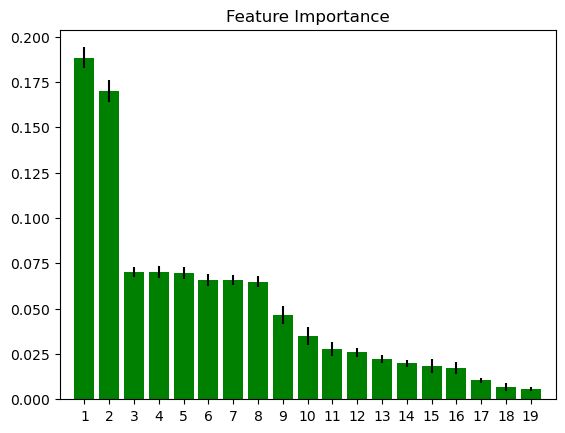

In [21]:
importances = rfc.feature_importances_ # feature's import
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis = 0)
indices = np.argsort(importances)[::-1] # Print out the feature importance ranking, -1 is to indicator ascending
print("Feature Ranking")
for f in range(xtrain.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, xtrain.columns[indices[f]], importances[indices[f]]))
plt.figure()
plt.title("Feature Importance")
plt.bar(range(xtrain.shape[1]), importances[indices], color = 'green', yerr = std[indices], align = 'center')
plt.xticks(range(xtrain.shape[1]), range(1,xtrain.shape[1]+1))
plt.xlim([-1, xtrain.shape[1]])
plt.show()

ROC curve

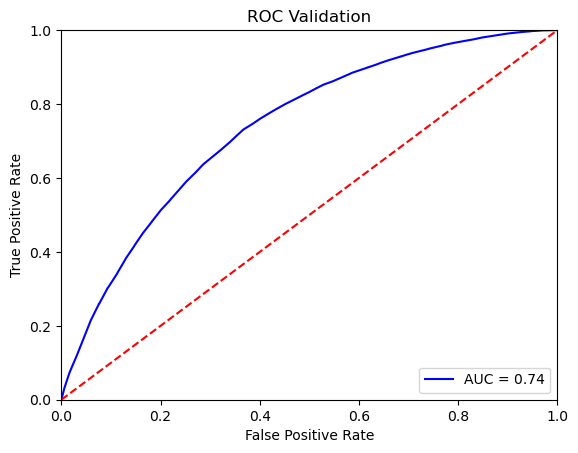

In [22]:
predictions_validation = rfc.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Next, we do CV to tune hyper-para. But first, we run a CART with 5-fold CV to see the accuracy result

In [23]:
clf = DecisionTreeClassifier(max_depth = None, min_samples_split= 2, random_state=127)
scores = cross_val_score(clf, xtrain, ytrain, cv=10, n_jobs=5)
print('CART has a mean accuracy of %0.4f after 10-fold CV' % scores.mean())

CART has a mean accuracy of 0.7370 after 10-fold CV


## Then we run 5-fold CV on RF

In [24]:
clf = RandomForestClassifier(n_estimators= 200, max_depth = None, min_samples_split=2, random_state=127)
scores = cross_val_score(clf, xtrain, ytrain, cv=10, n_jobs=5)
print('RF has a mean accuracy of %0.4f after 10-fold CV' % scores.mean())

RF has a mean accuracy of 0.8174 after 10-fold CV


### The hyper parameters that need to be tuned are: n_estimators(# of trees), min_samples_split (min # of samples required to split an internal node), min_samples_leaf(min # of samples required to be at a leaf node), max_depth, max_sample (proportion of the training samples given to each tree, max = 1, this will speed up if we can lower it),  max_features (max of features given to each tree, default is square.root of d. Conventialy , the ideal number is just around the default), criterion ('gini' or 'entropy'), class_weight (None or 'balanced')

### Do a Random serach first

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 60, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# max_sample, proportion of the training samples given to each tree, max = 1, this will speed up if we can lower it
max_sample = [0.2, 0.3, 0.4, 0.5]
# class_weight
class_weight = [None, 'balanced']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800], 'max_features': ['auto'], 'max_depth': [10, 15, 20, 25, 30, None], 'min_samples_split': [20, 60, 100], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 127)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 50, scoring='roc_auc', 
                              cv = 5, verbose=2, random_state=127, n_jobs=14,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


### random serach's best hyperparameters

In [ ]:
rf_random.best_params_

## Evaluate the best Random Search model

In [ ]:
best_random_model = rf_random.best_estimator_
roc_auc_score(ytest, best_random_model.predict_proba(xtest)[:,1])

### Do a Grid serach then

We can now perfrom grid search building on the result from the random search. We will test a range of hyperparameters around the best value return by random search. 

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [ ]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

In [ ]:
grid_search.best_params_

### Evaluate the Best Model from Grid Search

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))